In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
% matplotlib inline

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
device = torch.device("cuda")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P40'

In [51]:
train = pd.read_csv("full-corpus.csv")
train.head()

,Topic,Sentiment,TweetId,TweetDate,TweetText
0,apple,positive,126415614616154112,Tue Oct 18 21:53:25 +0000 2011,Now all @Apple has to do is get swype on the i...
1,apple,positive,126404574230740992,Tue Oct 18 21:09:33 +0000 2011,@Apple will be adding more carrier support to ...
2,apple,positive,126402758403305474,Tue Oct 18 21:02:20 +0000 2011,Hilarious @youtube video - guy does a duet wit...
3,apple,positive,126397179614068736,Tue Oct 18 20:40:10 +0000 2011,@RIM you made it too easy for me to switch to ...
4,apple,positive,126395626979196928,Tue Oct 18 20:34:00 +0000 2011,I just realized that the reason I got into twi...


In [52]:
train["Sentiment"].value_counts()

neutral       2333
irrelevant    1689
negative       572
positive       519
Name: Sentiment, dtype: int64

In [53]:
change_dict = {"neutral":1, "irrelevant":2, "negative":3, "positive":4}
rev_dict = {v:k for k,v in change_dict.items()}

def change(x):
    return change_dict[str(x)]

train["Sentiment"] = train["Sentiment"].apply(change)
train["Sentiment"].value_counts()

1    2333
2    1689
3     572
4     519
Name: Sentiment, dtype: int64

In [9]:
# Tokenization
sentences = ["[CLS] " + query + " [SEP]" for query in train["TweetText"]]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'now', 'all', '@', 'apple', 'has', 'to', 'do', 'is', 'get', 'sw', '##ype', 'on', 'the', 'iphone', 'and', 'it', 'will', 'be', 'crack', '.', 'iphone', 'that', 'is', '[SEP]']


In [10]:
MAX_LEN = max([len(x) for x in tokenized_texts]) 
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


In [11]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)   

In [17]:
labels = train["Sentiment"]

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=42, test_size=0.2)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs).long()
validation_inputs = torch.tensor(validation_inputs).long()
train_labels = torch.tensor(train_labels.values).long()
validation_labels = torch.tensor(validation_labels.values).long()
train_masks = torch.tensor(train_masks).long()
validation_masks = torch.tensor(validation_masks).long()

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [19]:
import torch.nn as nn

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [21]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

loss = nn.CrossEntropyLoss()

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
validation_loss_set = []

train_accuracy_set = []
validation_accuracy_set = []

# Number of training epochs 
epochs = 10

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
    ## TRAINING

    # Set our model to training mode
    model.train()  
    
    # Tracking variables
    train_loss, train_accuracy = 0, 0
    nb_train_steps, nb_train_examples = 0, 0
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)        
        lossout = loss(output, b_labels)   
        # Backward pass
        lossout.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update tracking variables
        logits = output.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_train_accuracy = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        nb_train_steps += 1
        
        tr_loss += lossout.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    train_loss_set.append(tr_loss/nb_tr_steps)
    train_accuracy_set.append(train_accuracy/nb_train_steps)
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    print("Train Accuracy: {}".format(train_accuracy/nb_train_steps))

       
    ## VALIDATION

    # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_ev_steps, nb_eval_examples = 0, 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
            lossout_val = loss(logits, b_labels)
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
        
        # Loss
        eval_loss += lossout_val.item()
        nb_eval_examples += b_input_ids.size(0)
        nb_ev_steps += 1
    validation_loss_set.append(eval_loss/nb_ev_steps)
    validation_accuracy_set.append(eval_accuracy/nb_eval_steps)        
    print("Validation loss: {}".format(eval_loss/nb_ev_steps))    
    print("Validation Accuracy: {} \n\n".format(eval_accuracy/nb_eval_steps))

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.4445915404940024
Train Accuracy: 0.8651216947115384


Epoch:  10%|█         | 1/10 [01:11<10:44, 71.57s/it]

Validation loss: 0.6333582038059831
Validation Accuracy: 0.8005922379032258 


Train loss: 0.38123802677728236
Train Accuracy: 0.8838078425480769


Epoch:  20%|██        | 2/10 [02:23<09:32, 71.56s/it]

Validation loss: 0.6805343674495816
Validation Accuracy: 0.8152406754032258 


Train loss: 0.3681973248603754
Train Accuracy: 0.8901554987980769


Epoch:  30%|███       | 3/10 [03:34<08:21, 71.58s/it]

Validation loss: 0.6856450131163001
Validation Accuracy: 0.8113344254032258 


Train loss: 0.3548241585958749
Train Accuracy: 0.8921086237980769


Epoch:  40%|████      | 4/10 [04:46<07:09, 71.59s/it]

Validation loss: 0.73488565441221
Validation Accuracy: 0.8113344254032258 


Train loss: 0.35000032861717045
Train Accuracy: 0.8925969050480769


Epoch:  50%|█████     | 5/10 [05:57<05:58, 71.61s/it]

Validation loss: 0.7500801673159003
Validation Accuracy: 0.7859438004032258 


Train loss: 0.3437673668959178
Train Accuracy: 0.8933856670673077


Epoch:  60%|██████    | 6/10 [07:09<04:46, 71.62s/it]

Validation loss: 0.8067738469690084
Validation Accuracy: 0.8044984879032258 


Train loss: 0.33823771052993834
Train Accuracy: 0.8948505108173077


Epoch:  70%|███████   | 7/10 [08:21<03:34, 71.63s/it]

Validation loss: 0.8449344094842672
Validation Accuracy: 0.7996471774193549 


Train loss: 0.34272111544851214
Train Accuracy: 0.8935171274038461


Epoch:  80%|████████  | 8/10 [09:32<02:23, 71.64s/it]

Validation loss: 0.8266486404463649
Validation Accuracy: 0.7966859879032258 


Train loss: 0.336889578087721
Train Accuracy: 0.8947190504807693


Epoch:  90%|█████████ | 9/10 [10:44<01:11, 71.65s/it]

Validation loss: 0.860868850722909
Validation Accuracy: 0.7927797379032258 


Train loss: 0.329862764920108
Train Accuracy: 0.8931978665865384


Epoch: 100%|██████████| 10/10 [11:56<00:00, 71.66s/it]

Validation loss: 0.8950178222730756
Validation Accuracy: 0.8045299899193549 




In [23]:
torch.save(model.state_dict(), "manually_curated_bert")

# BERT Curated

In [4]:
df = pd.read_csv("final bitcoin.csv")

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
model.load_state_dict(torch.load("manually_curated_bert"))
device = torch.device("cuda")
model = model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [5]:
text = df["text"]

# Tokenization
sentences = ["[CLS] " + query + " [SEP]" for query in text]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'the', 'first', 'lab', 'made', 'diamond', 'happened', 'in', 'amp', 'now', 'they', 'are', 'so', 'flawless', 'that', 'mined', 'diamonds', 'can', '##t', 'come', 'close', 'the', 'same', 'will', 'happen', 'to', 'gold', 'not', 'to', 'mention', 'the', 'massive', 'supply', 'available', 'on', 'asteroids', 'amp', 'other', 'sources', 'as', 'a', 'result', 'bit', '##co', '##in', 'is', 'a', 'necessary', 'part', 'of', 'human', 'evolution', '[SEP]']


In [6]:
MAX_LEN = max([len(x) for x in tokenized_texts]) 
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [7]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)    

In [8]:
inputs =  torch.tensor(input_ids).long().to(device)
masks = torch.tensor(attention_masks).long().to(device)

In [9]:
import time 
start = time.time()

logits = []
for x in range(inputs.shape[0]):
    with torch.no_grad():
        logits.append(model(inputs[x].unsqueeze(0), token_type_ids=None, attention_mask=masks[0].unsqueeze(0))) 
    
print(time.time() - start)

13051.555616140366


In [10]:
import pickle

with open("manually_curated_logits.pkl", 'wb') as save_file:
    pickle.dump(logits, save_file, -1)

/home/ky848/.local/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [14]:
logits = [x.cpu() for x in logits]
final = [np.argmax(x[0]).item() for x in logits]

AttributeError: 'int' object has no attribute 'cpu'

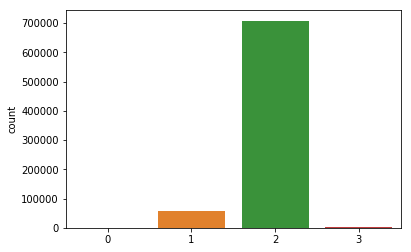

In [18]:
import seaborn as sns

sns.countplot(logits)

In [20]:
with open("manually_curated_sentiments.pkl", 'wb') as save_file:
    pickle.dump(logits, save_file, -1)